# Análise Operacional de Tempo 

**Objetivo Estratégico:** Otimizar operações para reduzir dependência de plataformas e maximizar performance do site próprio.

**Foco:** Análises temporais que gerem insights para decisões operacionais estratégicas.



In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações visuais
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11
plt.style.use('seaborn-v0_8')



## 1. Carregamento e Preparação dos Dados
Carregamento da base limpa e criação de segmentações temporais estratégicas.


In [96]:
df = pd.read_csv('tratamento_inicial/Base_Kaiserhaus_Limpa.csv')

print(" DADOS CARREGADOS")
print("=" * 50)
print(f"Registros: {len(df):,}")
print(f"Período: {df['order_datetime'].min()} até {df['order_datetime'].max()}")
print(f"Plataformas: {df['platform'].unique()}")

# Converter para datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df['hora'] = df['order_datetime'].dt.hour
df['dia_semana'] = df['order_datetime'].dt.day_name()
df['mes'] = df['order_datetime'].dt.month


 DADOS CARREGADOS
Registros: 5,000
Período: 2024-01-01 15:08:00 até 2024-12-31 21:27:00
Plataformas: ['rappi' 'ifood' 'site_proprio' 'whatsapp']


## 2. Criação de Segmentações Temporais Estratégicas
Segmentações focadas em otimização operacional e análise de performance por canal.


In [97]:
def criar_segmentacoes_temporais(df):
    df = df.copy()
    
    def periodo_dia(hora):
        if 0 <= hora < 6:
            return 'Madrugada'
        elif 6 <= hora < 12:
            return 'Manhã'
        elif 12 <= hora < 18:
            return 'Tarde'
        else:
            return 'Noite'
    
    df['periodo_dia'] = df['hora'].apply(periodo_dia)
    

    def intensidade_demanda(hora):
        if hora in [12, 13, 14, 19, 20]: 
            return 'Pico'
        elif hora in [11, 15, 16, 17, 18, 21]:  # Alta demanda
            return 'Alta'
        elif hora in [7, 8, 9, 10, 22]:  # Demanda média
            return 'Média'
        else:
            return 'Baixa'
    
    df['intensidade_demanda'] = df['hora'].apply(intensidade_demanda)
    
    # 3. Tipo de dia
    def tipo_dia(dia_semana):
        if dia_semana in ['Saturday', 'Sunday']:
            return 'Fim de Semana'
        else:
            return 'Dia Útil'
    
    df['tipo_dia'] = df['dia_semana'].apply(tipo_dia)
    
    # 4. Estação do ano (para análise de sazonalidade)
    def estacao(mes):
        if mes in [12, 1, 2]:
            return 'Verão'
        elif mes in [3, 4, 5]:
            return 'Outono'
        elif mes in [6, 7, 8]:
            return 'Inverno'
        else:
            return 'Primavera'
    
    df['estacao'] = df['mes'].apply(estacao)
    

    df['is_pico'] = df['hora'].isin([12, 13, 14, 19, 20])
    
    return df


df = criar_segmentacoes_temporais(df)

print("SEGMENTAÇÕES TEMPORAIS CRIADAS")
print("=" * 50)
print("\nPeríodo do dia:")
print(df['periodo_dia'].value_counts())
print("\nIntensidade de demanda:")
print(df['intensidade_demanda'].value_counts())
print("\nTipo de dia:")
print(df['tipo_dia'].value_counts())


SEGMENTAÇÕES TEMPORAIS CRIADAS

Período do dia:
periodo_dia
Tarde        1897
Noite        1569
Manhã        1399
Madrugada     135
Name: count, dtype: int64

Intensidade de demanda:
intensidade_demanda
Pico     2084
Alta     1580
Média    1080
Baixa     256
Name: count, dtype: int64

Tipo de dia:
tipo_dia
Dia Útil         3540
Fim de Semana    1460
Name: count, dtype: int64


## 3. Análise Comparativa de Performance por Plataforma
**Objetivo:** Entender vantagens competitivas do site próprio vs plataformas.


In [98]:
print("ANÁLISE COMPARATIVA DE PLATAFORMAS")
print("=" * 60)
print("Objetivo: Identificar vantagens competitivas do site próprio")
print()

# Análise de performance operacional por plataforma
performance_plataformas = df.groupby('platform').agg({
    'tempo_preparo_minutos': ['count', 'mean', 'std'],
    'actual_delivery_minutes': ['mean', 'std'],
    'eta_minutes_quote': 'mean',
    'satisfacao_nivel': ['mean', 'std'],
    'total_brl': ['mean', 'sum'],
    'platform_commission_pct': 'mean'
}).round(2)

print("PERFORMANCE OPERACIONAL POR PLATAFORMA:")
print(performance_plataformas)
print()

# Análise de precisão do ETA
df['diferenca_eta'] = df['actual_delivery_minutes'] - df['eta_minutes_quote']
df['precisao_eta'] = abs(df['diferenca_eta'])

precisao_plataformas = df.groupby('platform').agg({
    'diferenca_eta': 'mean',
    'precisao_eta': 'mean',
    'satisfacao_nivel': 'mean'
}).round(2)

print("PRECISÃO DO ETA E SATISFAÇÃO:")
print(precisao_plataformas)
print()

# Identificar vantagens do site próprio
site_proprio = df[df['platform'] == 'site_proprio']
outras_plataformas = df[df['platform'] != 'site_proprio']

print("VANTAGENS DO SITE PRÓPRIO:")
print(f"Tempo médio de entrega: {site_proprio['actual_delivery_minutes'].mean():.1f} min vs {outras_plataformas['actual_delivery_minutes'].mean():.1f} min")
print(f"Satisfação média: {site_proprio['satisfacao_nivel'].mean():.2f} vs {outras_plataformas['satisfacao_nivel'].mean():.2f}")
print(f"Precisão do ETA: {site_proprio['precisao_eta'].mean():.1f} min vs {outras_plataformas['precisao_eta'].mean():.1f} min")
print(f"Comissão: {site_proprio['platform_commission_pct'].mean():.1%} vs {outras_plataformas['platform_commission_pct'].mean():.1%}")


ANÁLISE COMPARATIVA DE PLATAFORMAS
Objetivo: Identificar vantagens competitivas do site próprio

PERFORMANCE OPERACIONAL POR PLATAFORMA:
             tempo_preparo_minutos              actual_delivery_minutes  \
                             count   mean   std                    mean   
platform                                                                  
ifood                         2661  16.41  7.91                   32.03   
rappi                          747  16.28  7.87                   32.29   
site_proprio                  1052  16.62  7.99                   26.66   
whatsapp                       540  16.33  7.91                   19.26   

                    eta_minutes_quote satisfacao_nivel       total_brl  \
                std              mean             mean   std      mean   
platform                                                                 
ifood         12.07             40.57             4.66  0.62    111.26   
rappi         11.73             40.75    

## 4. Análise de Tempos Operacionais por Período
**Objetivo:** Identificar gargalos operacionais e oportunidades de otimização.
 

In [99]:
print("ANÁLISE DE TEMPOS OPERACIONAIS POR PERÍODO")
print("=" * 60)
print("Objetivo: Identificar gargalos e otimizar capacidade operacional")
print()

# Análise de tempos por período do dia
tempos_periodo = df.groupby('periodo_dia').agg({
    'tempo_preparo_minutos': ['count', 'mean', 'std'],
    'actual_delivery_minutes': ['mean', 'std'],
    'eta_minutes_quote': 'mean',
    'satisfacao_nivel': 'mean',
    'total_brl': 'mean'
}).round(2)

print("TEMPOS POR PERÍODO DO DIA:")
print(tempos_periodo)
print()

# Análise de intensidade de demanda
tempos_intensidade = df.groupby('intensidade_demanda').agg({
    'tempo_preparo_minutos': ['count', 'mean'],
    'actual_delivery_minutes': 'mean',
    'satisfacao_nivel': 'mean',
    'diferenca_eta': 'mean'
}).round(2)

print("TEMPOS POR INTENSIDADE DE DEMANDA:")
print(tempos_intensidade)
print()

# Análise de picos vs tempos
picos_analise = df.groupby('is_pico').agg({
    'tempo_preparo_minutos': ['count', 'mean'],
    'actual_delivery_minutes': 'mean',
    'satisfacao_nivel': 'mean',
    'diferenca_eta': 'mean'
}).round(2)

print("ANÁLISE DE PICOS vs TEMPOS:")
print(picos_analise)
print()

# Identificar gargalos operacionais
print("GARGALOS OPERACIONAIS IDENTIFICADOS:")
periodo_maior_tempo = df.groupby('periodo_dia')['tempo_preparo_minutos'].mean().idxmax()
maior_tempo = df.groupby('periodo_dia')['tempo_preparo_minutos'].mean().max()
print(f"Período com maior tempo de preparo: {periodo_maior_tempo} ({maior_tempo:.1f} min)")

intensidade_maior_tempo = df.groupby('intensidade_demanda')['tempo_preparo_minutos'].mean().idxmax()
maior_tempo_int = df.groupby('intensidade_demanda')['tempo_preparo_minutos'].mean().max()
print(f"Intensidade com maior tempo: {intensidade_maior_tempo} ({maior_tempo_int:.1f} min)")

print(f"Impacto dos picos: +{picos_analise.loc[True, ('tempo_preparo_minutos', 'mean')] - picos_analise.loc[False, ('tempo_preparo_minutos', 'mean')]:.1f} min no preparo")


ANÁLISE DE TEMPOS OPERACIONAIS POR PERÍODO
Objetivo: Identificar gargalos e otimizar capacidade operacional

TEMPOS POR PERÍODO DO DIA:
            tempo_preparo_minutos              actual_delivery_minutes         \
                            count   mean   std                    mean    std   
periodo_dia                                                                     
Madrugada                     135  17.44  8.88                   30.62  13.53   
Manhã                        1399  16.65  7.89                   29.72  12.69   
Noite                        1569  16.22  7.94                   29.32  12.75   
Tarde                        1897  16.34  7.86                   29.57  12.48   

            eta_minutes_quote satisfacao_nivel total_brl  
                         mean             mean      mean  
periodo_dia                                               
Madrugada               36.83             4.64    113.29  
Manhã                   37.44             4.73    110.82  
N

## 5. Análise de Precisão do ETA por Plataforma e Período
**Objetivo:** Otimizar estimativas para competir melhor com plataformas.
o

In [100]:
print("ANÁLISE DE PRECISÃO DO ETA")
print("=" * 50)
print("Objetivo: Melhorar estimativas para competir com plataformas")
print()

# Análise de precisão por plataforma
precisao_plataforma = df.groupby('platform').agg({
    'diferenca_eta': ['mean', 'std'],
    'precisao_eta': ['mean', 'std'],
    'satisfacao_nivel': 'mean'
}).round(2)

print("PRECISÃO DO ETA POR PLATAFORMA:")
print(precisao_plataforma)
print()

# Análise de precisão por período
precisao_periodo = df.groupby('periodo_dia').agg({
    'diferenca_eta': ['mean', 'std'],
    'precisao_eta': ['mean', 'std'],
    'satisfacao_nivel': 'mean'
}).round(2)

print("PRECISÃO DO ETA POR PERÍODO:")
print(precisao_periodo)
print()

# Análise de precisão por intensidade de demanda
precisao_intensidade = df.groupby('intensidade_demanda').agg({
    'diferenca_eta': ['mean', 'std'],
    'precisao_eta': ['mean', 'std'],
    'satisfacao_nivel': 'mean'
}).round(2)

print("PRECISÃO DO ETA POR INTENSIDADE:")
print(precisao_intensidade)
print()

# Identificar oportunidades de melhoria
print("OPORTUNIDADES DE MELHORIA:")
plataforma_menos_precisa = df.groupby('platform')['precisao_eta'].mean().idxmax()
menor_precisao = df.groupby('platform')['precisao_eta'].mean().max()
print(f"Plataforma menos precisa: {plataforma_menos_precisa} ({menor_precisao:.1f} min de erro)")

periodo_menos_preciso = df.groupby('periodo_dia')['precisao_eta'].mean().idxmax()
menor_precisao_periodo = df.groupby('periodo_dia')['precisao_eta'].mean().max()
print(f"Período menos preciso: {periodo_menos_preciso} ({menor_precisao_periodo:.1f} min de erro)")

# Análise de correlação precisão x satisfação
correlacao_precisao_satisfacao = df['precisao_eta'].corr(df['satisfacao_nivel'])
print(f"Correlação precisão x satisfação: {correlacao_precisao_satisfacao:.3f}")

if correlacao_precisao_satisfacao < -0.1:
    print("Maior precisão está relacionada a maior satisfação!")
else:
    print(" Precisão não é o principal fator de satisfação")


ANÁLISE DE PRECISÃO DO ETA
Objetivo: Melhorar estimativas para competir com plataformas

PRECISÃO DO ETA POR PLATAFORMA:
             diferenca_eta       precisao_eta       satisfacao_nivel
                      mean   std         mean   std             mean
platform                                                            
ifood                -8.54  9.44        10.76  6.79             4.66
rappi                -8.46  9.17        10.58  6.61             4.66
site_proprio         -7.32  9.10         9.62  6.62             4.90
whatsapp             -5.27  8.09         8.06  5.33             4.90

PRECISÃO DO ETA POR PERÍODO:
            diferenca_eta        precisao_eta       satisfacao_nivel
                     mean    std         mean   std             mean
periodo_dia                                                         
Madrugada           -6.21  10.07         9.55  6.96             4.64
Manhã               -7.72   9.21        10.04  6.59             4.73
Noite               -

PRECISÃO DO ETA POR INTENSIDADE:
                    diferenca_eta       precisao_eta       satisfacao_nivel
                             mean   std         mean   std             mean
intensidade_demanda                                                        
Alta                        -7.79  9.12        10.07  6.53             4.73
Baixa                       -6.78  9.63         9.70  6.66             4.69
Média                       -7.85  9.19        10.16  6.54             4.73
Pico                        -8.19  9.32        10.39  6.77             4.75

OPORTUNIDADES DE MELHORIA:
Plataforma menos precisa: ifood (10.8 min de erro)
Período menos preciso: Noite (10.5 min de erro)
Correlação precisão x satisfação: 0.161
 Precisão não é o principal fator de satisfação


## 6. Análise de Correlações Temporais e Satisfação
**Objetivo:** Entender como tempos operacionais impactam a satisfação do cliente.


In [101]:
print("ANÁLISE DE CORRELAÇÕES TEMPORAIS")
print("=" * 50)
print("Objetivo: Entender impacto dos tempos na satisfação")
print()

# Correlações entre variáveis temporais e satisfação
variaveis_tempo = ['tempo_preparo_minutos', 'actual_delivery_minutes', 
                   'eta_minutes_quote', 'diferenca_eta', 'precisao_eta']

correlacoes = df[variaveis_tempo + ['satisfacao_nivel']].corr()['satisfacao_nivel'].drop('satisfacao_nivel')

print("CORRELAÇÕES COM SATISFAÇÃO:")
for var, corr in correlacoes.items():
    print(f"{var}: {corr:.3f}")
print()

# Análise de satisfação por plataforma e período
satisfacao_plataforma_periodo = df.groupby(['platform', 'periodo_dia'])['satisfacao_nivel'].mean().unstack().round(2)

print("SATISFAÇÃO POR PLATAFORMA E PERÍODO:")
print(satisfacao_plataforma_periodo)
print()

# Análise de satisfação por intensidade de demanda
satisfacao_intensidade = df.groupby('intensidade_demanda')['satisfacao_nivel'].agg(['mean', 'std', 'count']).round(2)

print("SATISFAÇÃO POR INTENSIDADE DE DEMANDA:")
print(satisfacao_intensidade)
print()

# Identificar padrões de satisfação
print("PADRÕES DE SATISFAÇÃO IDENTIFICADOS:")
melhor_plataforma = df.groupby('platform')['satisfacao_nivel'].mean().idxmax()
melhor_satisfacao = df.groupby('platform')['satisfacao_nivel'].mean().max()
print(f"Melhor plataforma: {melhor_plataforma} ({melhor_satisfacao:.2f})")

melhor_periodo = df.groupby('periodo_dia')['satisfacao_nivel'].mean().idxmax()
melhor_satisfacao_periodo = df.groupby('periodo_dia')['satisfacao_nivel'].mean().max()
print(f"Melhor período: {melhor_periodo} ({melhor_satisfacao_periodo:.2f})")

melhor_intensidade = df.groupby('intensidade_demanda')['satisfacao_nivel'].mean().idxmax()
melhor_satisfacao_int = df.groupby('intensidade_demanda')['satisfacao_nivel'].mean().max()
print(f"Melhor intensidade: {melhor_intensidade} ({melhor_satisfacao_int:.2f})")

# Análise de impacto dos picos na satisfação
satisfacao_picos = df.groupby('is_pico')['satisfacao_nivel'].mean()
diferenca_picos = satisfacao_picos[True] - satisfacao_picos[False]
print(f"Impacto dos picos na satisfação: {diferenca_picos:+.2f}")

if diferenca_picos < -0.1:
    print(" Picos reduzem significativamente a satisfação!")
elif diferenca_picos > 0.1:
    print(" Picos aumentam a satisfação (possível viés nos dados)")
else:
    print(" Picos não impactam significativamente a satisfação")


ANÁLISE DE CORRELAÇÕES TEMPORAIS
Objetivo: Entender impacto dos tempos na satisfação

CORRELAÇÕES COM SATISFAÇÃO:
tempo_preparo_minutos: -0.586
actual_delivery_minutes: -0.640
eta_minutes_quote: -0.219
diferenca_eta: -0.673
precisao_eta: 0.161

SATISFAÇÃO POR PLATAFORMA E PERÍODO:
periodo_dia   Madrugada  Manhã  Noite  Tarde
platform                                    
ifood              4.47   4.66   4.65   4.68
rappi              4.74   4.61   4.65   4.72
site_proprio       4.74   4.90   4.91   4.91
whatsapp           4.96   4.88   4.92   4.89

SATISFAÇÃO POR INTENSIDADE DE DEMANDA:
                     mean   std  count
intensidade_demanda                   
Alta                 4.73  0.55   1580
Baixa                4.69  0.60    256
Média                4.73  0.54   1080
Pico                 4.75  0.55   2084

PADRÕES DE SATISFAÇÃO IDENTIFICADOS:
Melhor plataforma: site_proprio (4.90)
Melhor período: Tarde (4.75)
Melhor intensidade: Pico (4.75)
Impacto dos picos na satisfação: +0.

## 7. Análise de Capacidade Operacional
**Objetivo:** Identificar gargalos e oportunidades de otimização da capacidade.


In [102]:
print("ANÁLISE DE CAPACIDADE OPERACIONAL")
print("=" * 50)
print("Objetivo: Identificar gargalos e otimizar capacidade")
print()

# Análise de distribuição de pedidos por hora
pedidos_por_hora = df.groupby('hora').size()
pedidos_por_hora_pct = (pedidos_por_hora / len(df) * 100).round(1)

print("DISTRIBUIÇÃO DE PEDIDOS POR HORA:")
print("Hora | Pedidos | %")
for hora in sorted(pedidos_por_hora.index):
    print(f"{hora:2d}h | {pedidos_por_hora[hora]:6d} | {pedidos_por_hora_pct[hora]:4.1f}%")
print()

# Identificar picos de demanda
picos_hora = pedidos_por_hora.nlargest(5)
print("TOP 5 PICOS DE DEMANDA:")
for hora, pedidos in picos_hora.items():
    print(f"• {hora}h: {pedidos} pedidos ({pedidos_por_hora_pct[hora]:.1f}%)")
print()

# Análise de capacidade por período
capacidade_periodo = df.groupby('periodo_dia').agg({
    'tempo_preparo_minutos': ['count', 'mean'],
    'actual_delivery_minutes': 'mean',
    'satisfacao_nivel': 'mean'
}).round(2)

print("CAPACIDADE POR PERÍODO:")
print(capacidade_periodo)
print()

# Análise de eficiência operacional
df['tempo_total_estimado'] = df['tempo_preparo_minutos'] + df['eta_minutes_quote']
df['tempo_total_real'] = df['tempo_preparo_minutos'] + df['actual_delivery_minutes']
df['eficiencia_operacional'] = df['tempo_total_estimado'] / df['tempo_total_real']

eficiencia_plataforma = df.groupby('platform')['eficiencia_operacional'].mean().round(3)
print("EFICIÊNCIA OPERACIONAL POR PLATAFORMA:")
print("(1.0 = perfeita, >1.0 = subestimou, <1.0 = superestimou)")
for platform, eficiencia in eficiencia_plataforma.items():
    print(f"• {platform}: {eficiencia:.3f}")
print()

# Identificar gargalos operacionais
print("GARGALOS OPERACIONAIS IDENTIFICADOS:")
periodo_maior_preparo = df.groupby('periodo_dia')['tempo_preparo_minutos'].mean().idxmax()
maior_preparo = df.groupby('periodo_dia')['tempo_preparo_minutos'].mean().max()
print(f"Período com maior tempo de preparo: {periodo_maior_preparo} ({maior_preparo:.1f} min)")

periodo_maior_entrega = df.groupby('periodo_dia')['actual_delivery_minutes'].mean().idxmax()
maior_entrega = df.groupby('periodo_dia')['actual_delivery_minutes'].mean().max()
print(f"Período com maior tempo de entrega: {periodo_maior_entrega} ({maior_entrega:.1f} min)")

# Análise de impacto dos picos na eficiência
eficiencia_picos = df.groupby('is_pico')['eficiencia_operacional'].mean()
diferenca_eficiencia = eficiencia_picos[True] - eficiencia_picos[False]
print(f"Impacto dos picos na eficiência: {diferenca_eficiencia:+.3f}")

if diferenca_eficiencia < -0.05:
    print("  Picos reduzem significativamente a eficiência!")
elif diferenca_eficiencia > 0.05:
    print("  Picos aumentam a eficiência (possível viés)")
else:
    print("  Picos não impactam significativamente a eficiência")


ANÁLISE DE CAPACIDADE OPERACIONAL
Objetivo: Identificar gargalos e otimizar capacidade

DISTRIBUIÇÃO DE PEDIDOS POR HORA:
Hora | Pedidos | %
 0h |     39 |  0.8%
 1h |     25 |  0.5%
 2h |     13 |  0.3%
 3h |     11 |  0.2%
 4h |     21 |  0.4%
 5h |     26 |  0.5%
 6h |     83 |  1.7%
 7h |    168 |  3.4%
 8h |    179 |  3.6%
 9h |    270 |  5.4%
10h |    326 |  6.5%
11h |    373 |  7.5%
12h |    461 |  9.2%
13h |    468 |  9.4%
14h |    369 |  7.4%
15h |    244 |  4.9%
16h |    164 |  3.3%
17h |    191 |  3.8%
18h |    252 |  5.0%
19h |    387 |  7.7%
20h |    399 |  8.0%
21h |    356 |  7.1%
22h |    137 |  2.7%
23h |     38 |  0.8%

TOP 5 PICOS DE DEMANDA:
• 13h: 468 pedidos (9.4%)
• 12h: 461 pedidos (9.2%)
• 20h: 399 pedidos (8.0%)
• 19h: 387 pedidos (7.7%)
• 11h: 373 pedidos (7.5%)

CAPACIDADE POR PERÍODO:
            tempo_preparo_minutos        actual_delivery_minutes  \
                            count   mean                    mean   
periodo_dia                            

## 8. Visualizações Estratégicas
**Objetivo:** Gráficos para insights visuais e tomada de decisão.


VISUALIZAÇÕES ESTRATÉGICAS


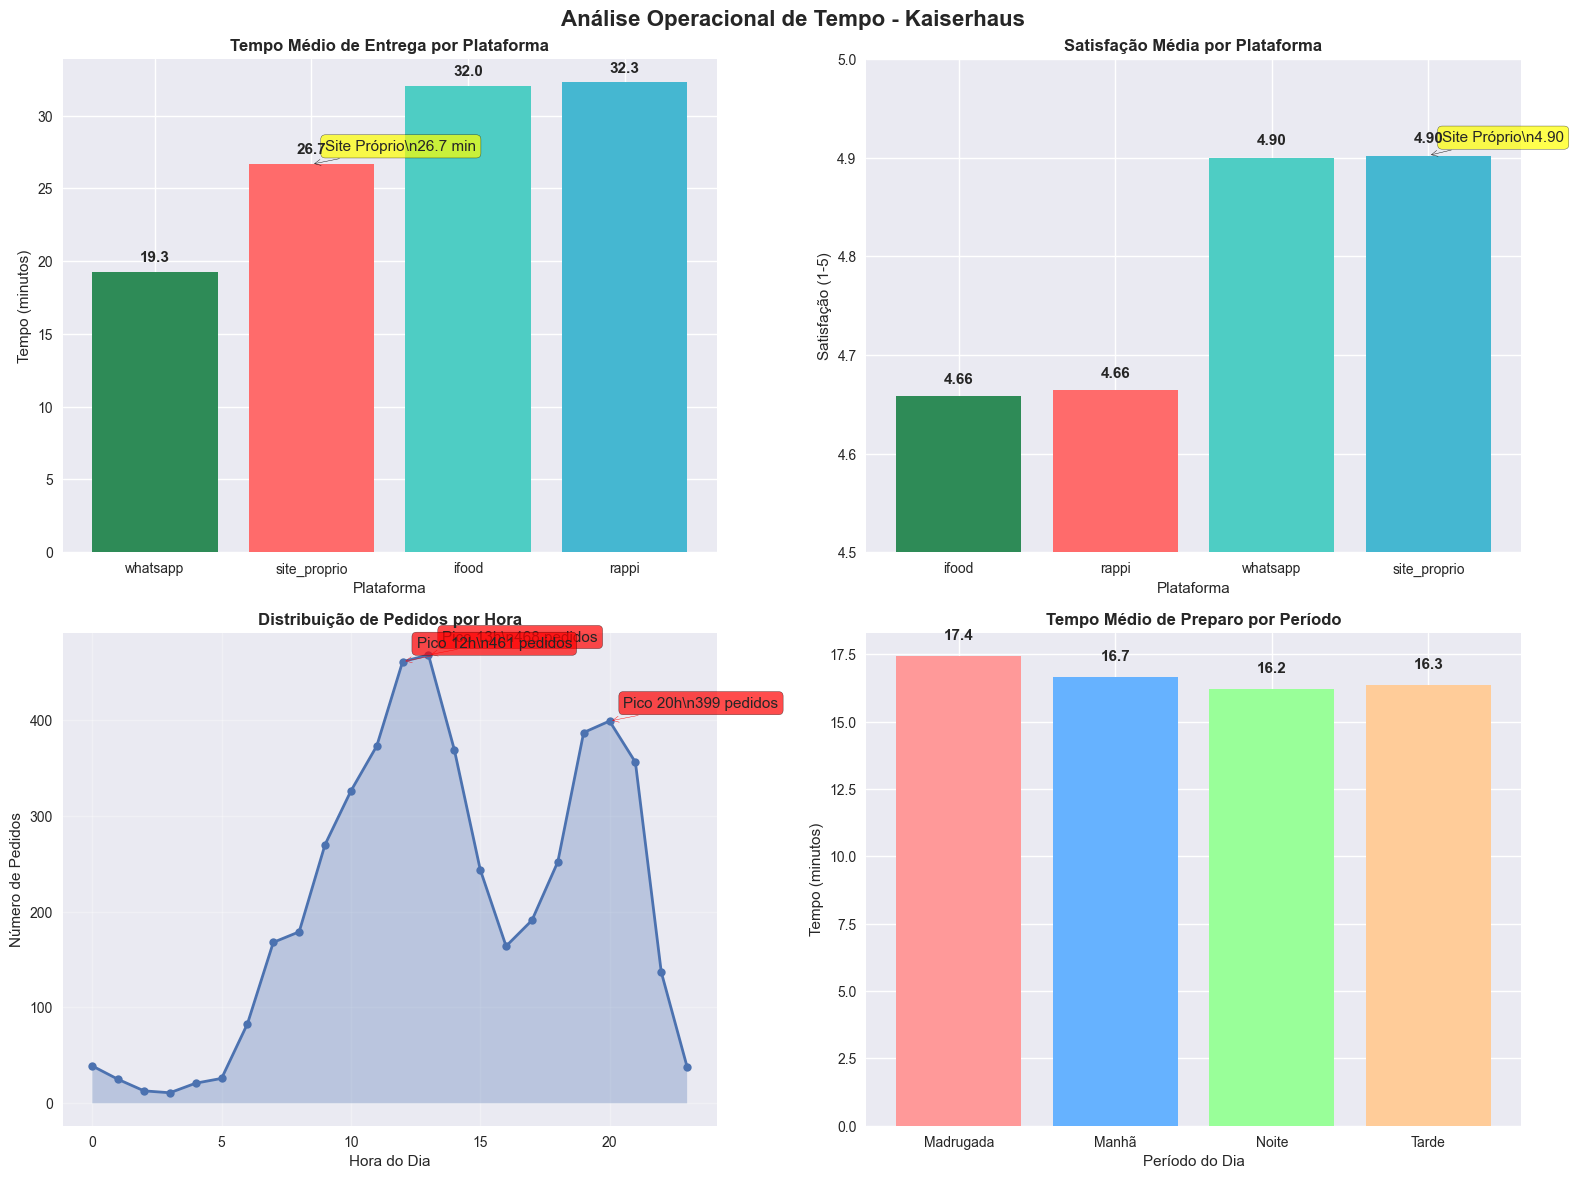

In [103]:
# 1. GRÁFICO DE PERFORMANCE POR PLATAFORMA
print("VISUALIZAÇÕES ESTRATÉGICAS")
print("=" * 50)

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise Operacional de Tempo - Kaiserhaus', fontsize=16, fontweight='bold')

# Gráfico 1: Tempo de entrega por plataforma
ax1 = axes[0, 0]
tempo_plataforma = df.groupby('platform')['actual_delivery_minutes'].mean().sort_values(ascending=True)
bars1 = ax1.bar(tempo_plataforma.index, tempo_plataforma.values, 
                color=['#2E8B57', '#FF6B6B', '#4ECDC4', '#45B7D1'])
ax1.set_title('Tempo Médio de Entrega por Plataforma', fontweight='bold')
ax1.set_ylabel('Tempo (minutos)')
ax1.set_xlabel('Plataforma')

# Destacar site próprio
site_proprio_tempo = tempo_plataforma['site_proprio']
ax1.annotate(f'Site Próprio\\n{site_proprio_tempo:.1f} min', 
             xy=('site_proprio', site_proprio_tempo),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adicionar valores nas barras
for i, v in enumerate(tempo_plataforma.values):
    ax1.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Satisfação por plataforma
ax2 = axes[0, 1]
satisfacao_plataforma = df.groupby('platform')['satisfacao_nivel'].mean().sort_values(ascending=True)
bars2 = ax2.bar(satisfacao_plataforma.index, satisfacao_plataforma.values,
                color=['#2E8B57', '#FF6B6B', '#4ECDC4', '#45B7D1'])
ax2.set_title('Satisfação Média por Plataforma', fontweight='bold')
ax2.set_ylabel('Satisfação (1-5)')
ax2.set_xlabel('Plataforma')
ax2.set_ylim(4.5, 5.0)

# Destacar site próprio
site_proprio_sat = satisfacao_plataforma['site_proprio']
ax2.annotate(f'Site Próprio\\n{site_proprio_sat:.2f}', 
             xy=('site_proprio', site_proprio_sat),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Adicionar valores nas barras
for i, v in enumerate(satisfacao_plataforma.values):
    ax2.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# Gráfico 3: Distribuição de pedidos por hora
ax3 = axes[1, 0]
pedidos_hora = df.groupby('hora').size()
ax3.plot(pedidos_hora.index, pedidos_hora.values, marker='o', linewidth=2, markersize=6)
ax3.fill_between(pedidos_hora.index, pedidos_hora.values, alpha=0.3)
ax3.set_title('Distribuição de Pedidos por Hora', fontweight='bold')
ax3.set_xlabel('Hora do Dia')
ax3.set_ylabel('Número de Pedidos')
ax3.grid(True, alpha=0.3)

# Destacar picos
picos = pedidos_hora.nlargest(3)
for hora, pedidos in picos.items():
    ax3.annotate(f'Pico {hora}h\\n{pedidos} pedidos', 
                 xy=(hora, pedidos), xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', color='red'))

# Gráfico 4: Tempo de preparo por período
ax4 = axes[1, 1]
tempo_periodo = df.groupby('periodo_dia')['tempo_preparo_minutos'].mean()
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
bars4 = ax4.bar(tempo_periodo.index, tempo_periodo.values, color=colors)
ax4.set_title('Tempo Médio de Preparo por Período', fontweight='bold')
ax4.set_ylabel('Tempo (minutos)')
ax4.set_xlabel('Período do Dia')

# Adicionar valores nas barras
for i, v in enumerate(tempo_periodo.values):
    ax4.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



ANÁLISE DE CORRELAÇÕES E HEATMAPS


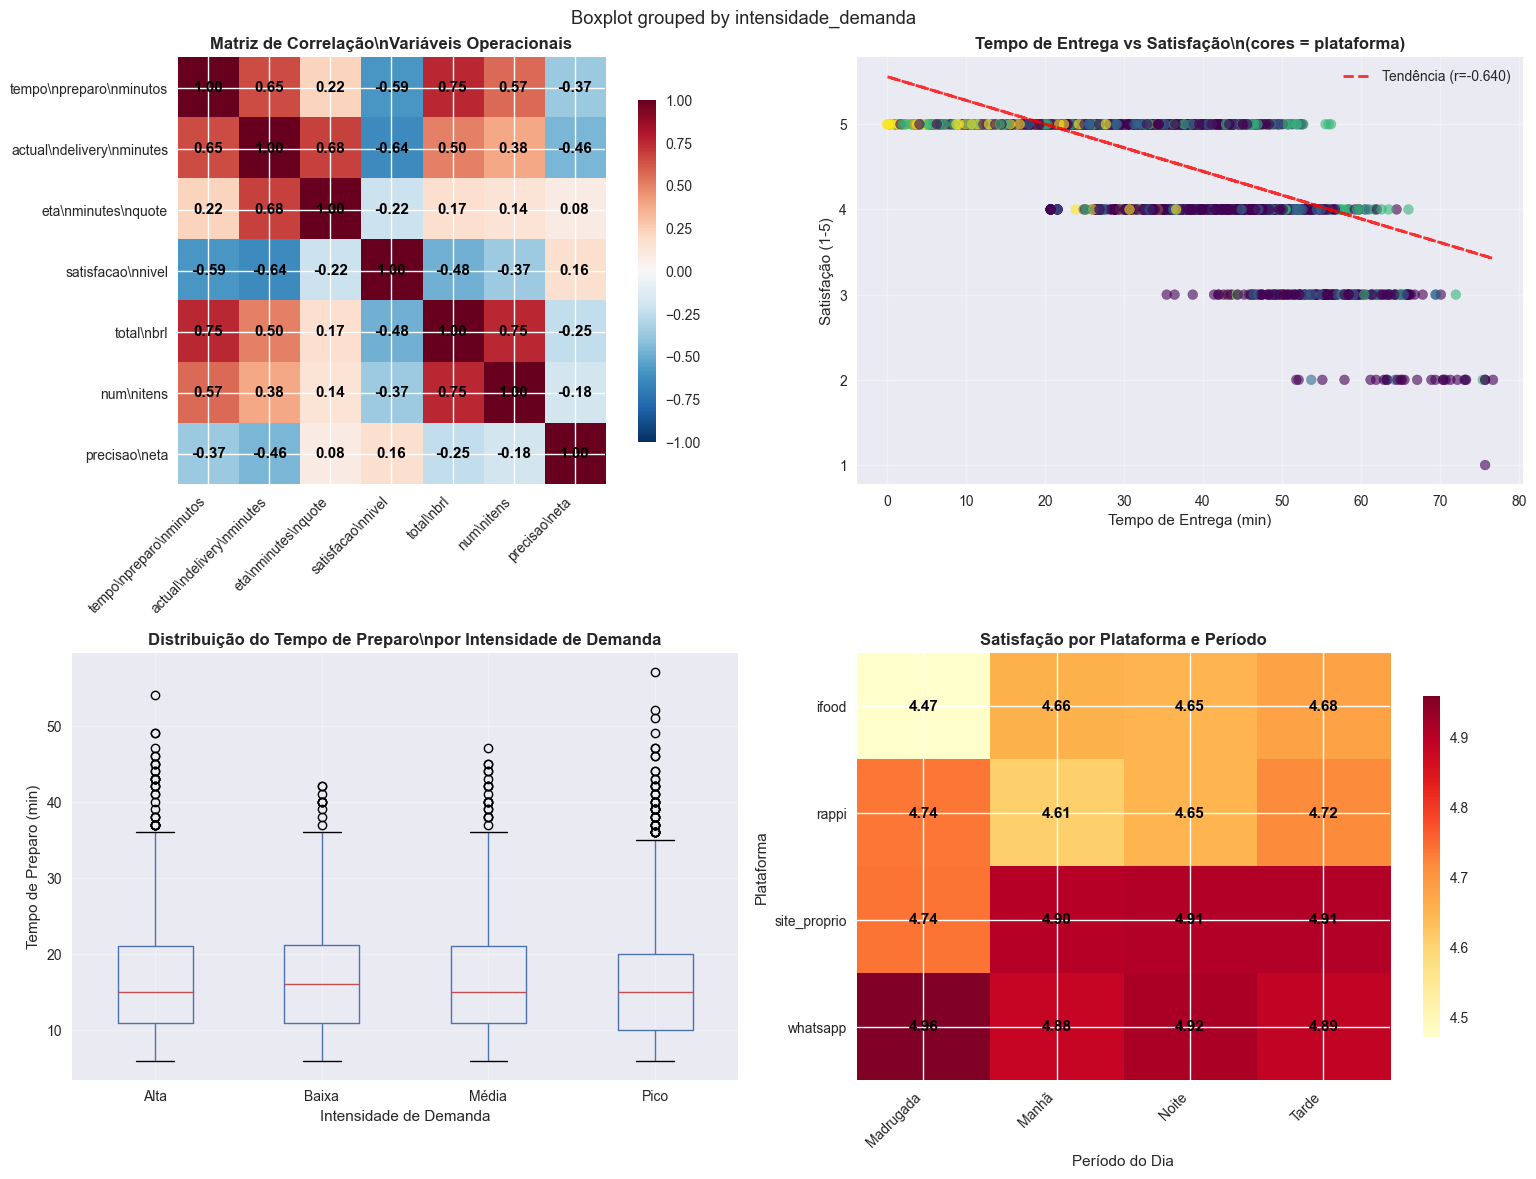

In [104]:
# 2. ANÁLISE DE CORRELAÇÕES E HEATMAPS
print("ANÁLISE DE CORRELAÇÕES E HEATMAPS")
print("=" * 50)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise de Correlações e Padrões Temporais', fontsize=16, fontweight='bold')

# Gráfico 1: Matriz de correlação
ax1 = axes[0, 0]
variaveis_corr = ['tempo_preparo_minutos', 'actual_delivery_minutes', 'eta_minutes_quote', 
                  'satisfacao_nivel', 'total_brl', 'num_itens', 'precisao_eta']
corr_matrix = df[variaveis_corr].corr()

im1 = ax1.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_xticks(range(len(variaveis_corr)))
ax1.set_yticks(range(len(variaveis_corr)))
ax1.set_xticklabels([v.replace('_', '\\n') for v in variaveis_corr], rotation=45, ha='right')
ax1.set_yticklabels([v.replace('_', '\\n') for v in variaveis_corr])

# Adicionar valores na matriz
for i in range(len(variaveis_corr)):
    for j in range(len(variaveis_corr)):
        text = ax1.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax1.set_title('Matriz de Correlação\\nVariáveis Operacionais', fontweight='bold')
plt.colorbar(im1, ax=ax1, shrink=0.8)

# Gráfico 2: Scatter plot - Tempo vs Satisfação
ax2 = axes[0, 1]
scatter = ax2.scatter(df['actual_delivery_minutes'], df['satisfacao_nivel'], 
                     c=df['platform'].astype('category').cat.codes, 
                     cmap='viridis', alpha=0.6, s=50)
ax2.set_xlabel('Tempo de Entrega (min)')
ax2.set_ylabel('Satisfação (1-5)')
ax2.set_title('Tempo de Entrega vs Satisfação\\n(cores = plataforma)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Adicionar linha de tendência
z = np.polyfit(df['actual_delivery_minutes'], df['satisfacao_nivel'], 1)
p = np.poly1d(z)
ax2.plot(df['actual_delivery_minutes'], p(df['actual_delivery_minutes']), 
         "r--", alpha=0.8, linewidth=2, label=f'Tendência (r={df["actual_delivery_minutes"].corr(df["satisfacao_nivel"]):.3f})')
ax2.legend()

# Gráfico 3: Boxplot - Tempo de preparo por intensidade
ax3 = axes[1, 0]
df.boxplot(column='tempo_preparo_minutos', by='intensidade_demanda', ax=ax3)
ax3.set_title('Distribuição do Tempo de Preparo\\npor Intensidade de Demanda', fontweight='bold')
ax3.set_xlabel('Intensidade de Demanda')
ax3.set_ylabel('Tempo de Preparo (min)')
ax3.grid(True, alpha=0.3)

# Gráfico 4: Heatmap de satisfação por plataforma e período
ax4 = axes[1, 1]
satisfacao_heatmap = df.groupby(['platform', 'periodo_dia'])['satisfacao_nivel'].mean().unstack()
im4 = ax4.imshow(satisfacao_heatmap.values, cmap='YlOrRd', aspect='auto')
ax4.set_xticks(range(len(satisfacao_heatmap.columns)))
ax4.set_yticks(range(len(satisfacao_heatmap.index)))
ax4.set_xticklabels(satisfacao_heatmap.columns, rotation=45, ha='right')
ax4.set_yticklabels(satisfacao_heatmap.index)

# Adicionar valores no heatmap
for i in range(len(satisfacao_heatmap.index)):
    for j in range(len(satisfacao_heatmap.columns)):
        text = ax4.text(j, i, f'{satisfacao_heatmap.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontweight='bold')

ax4.set_title('Satisfação por Plataforma e Período', fontweight='bold')
ax4.set_xlabel('Período do Dia')
ax4.set_ylabel('Plataforma')
plt.colorbar(im4, ax=ax4, shrink=0.8)

plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'Distribuição de Pedidos\\npor Período')

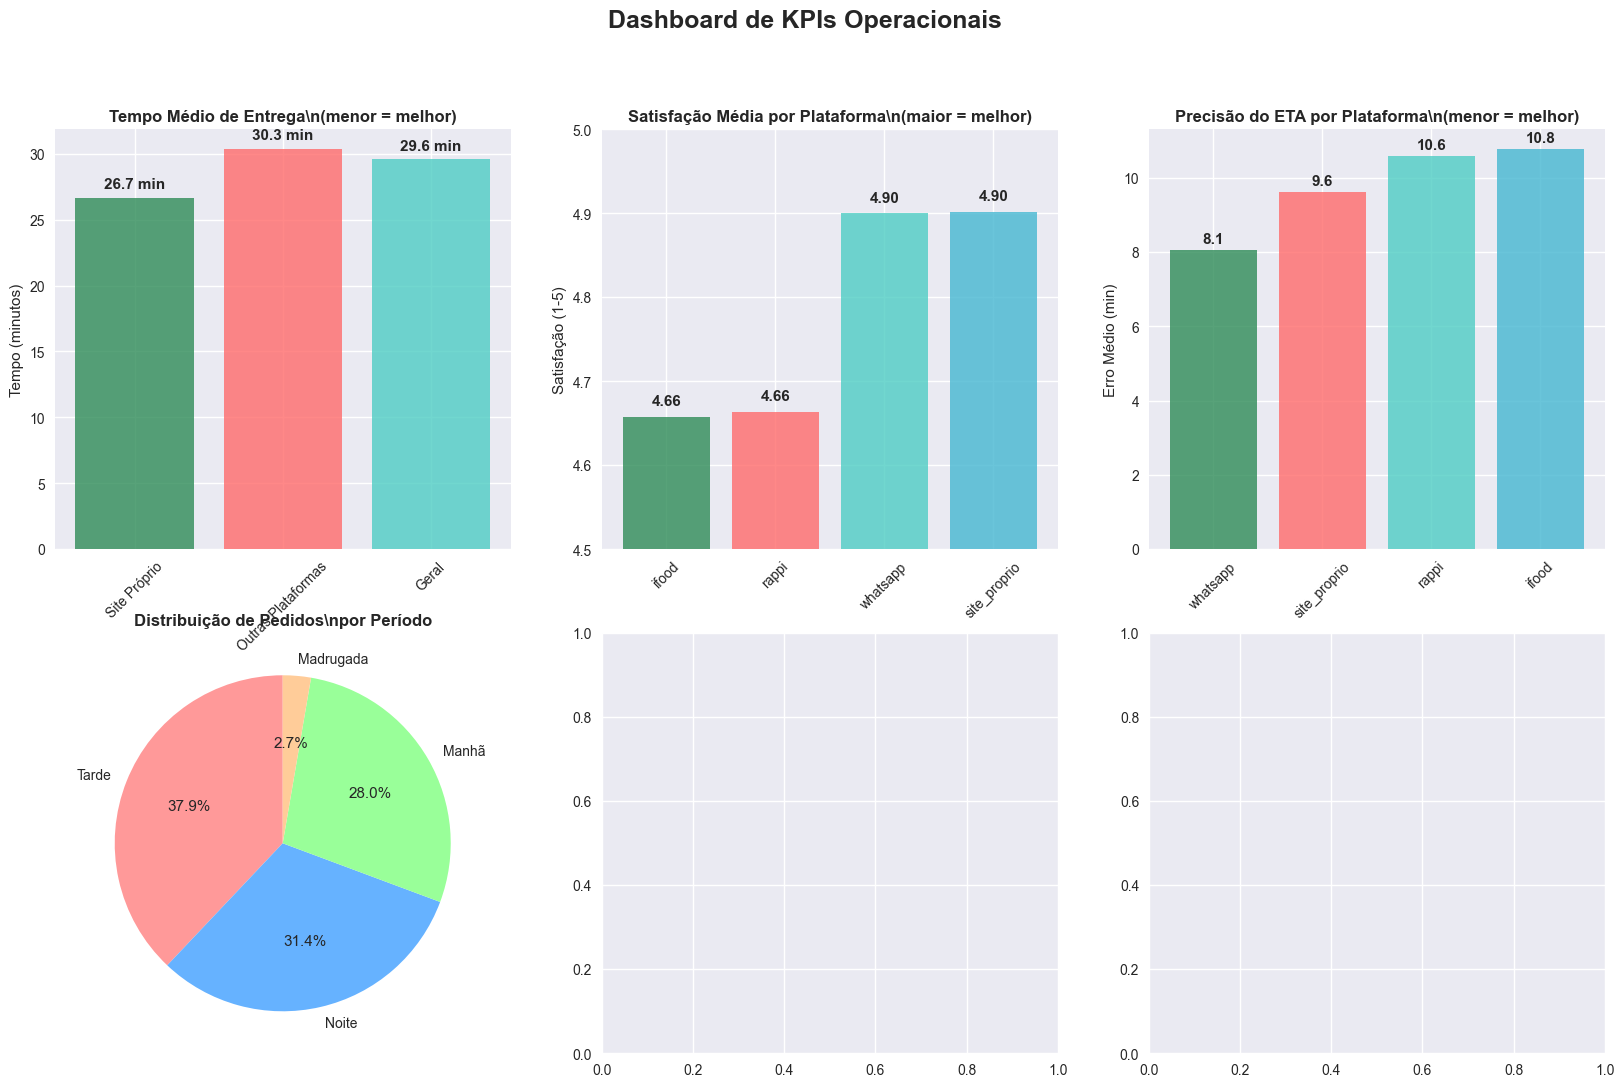

In [105]:


# Criar dashboard com KPIs principais
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Dashboard de KPIs Operacionais', fontsize=18, fontweight='bold')

# KPI 1: Tempo médio de entrega por plataforma
ax1 = axes[0, 0]
tempo_medio_geral = df['actual_delivery_minutes'].mean()
tempo_site_proprio = df[df['platform'] == 'site_proprio']['actual_delivery_minutes'].mean()
tempo_outras = df[df['platform'] != 'site_proprio']['actual_delivery_minutes'].mean()

categories = ['Site Próprio', 'Outras Plataformas', 'Geral']
values = [tempo_site_proprio, tempo_outras, tempo_medio_geral]
colors = ['#2E8B57', '#FF6B6B', '#4ECDC4']

bars1 = ax1.bar(categories, values, color=colors, alpha=0.8)
ax1.set_title('Tempo Médio de Entrega\\n(menor = melhor)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Tempo (minutos)')
ax1.tick_params(axis='x', rotation=45)

# Adicionar valores
for i, v in enumerate(values):
    ax1.text(i, v + 0.5, f'{v:.1f} min', ha='center', va='bottom', fontweight='bold')

# KPI 2: Satisfação média por plataforma
ax2 = axes[0, 1]
satisfacao_media = df.groupby('platform')['satisfacao_nivel'].mean().sort_values(ascending=True)
bars2 = ax2.bar(satisfacao_media.index, satisfacao_media.values, 
                color=['#2E8B57', '#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax2.set_title('Satisfação Média por Plataforma\\n(maior = melhor)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Satisfação (1-5)')
ax2.set_ylim(4.5, 5.0)
ax2.tick_params(axis='x', rotation=45)

# Adicionar valores
for i, v in enumerate(satisfacao_media.values):
    ax2.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# KPI 3: Precisão do ETA por plataforma
ax3 = axes[0, 2]
precisao_eta = df.groupby('platform')['precisao_eta'].mean().sort_values(ascending=True)
bars3 = ax3.bar(precisao_eta.index, precisao_eta.values,
                color=['#2E8B57', '#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
ax3.set_title('Precisão do ETA por Plataforma\\n(menor = melhor)', fontweight='bold', fontsize=12)
ax3.set_ylabel('Erro Médio (min)')
ax3.tick_params(axis='x', rotation=45)

# Adicionar valores
for i, v in enumerate(precisao_eta.values):
    ax3.text(i, v + 0.1, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

# KPI 4: Distribuição de pedidos por período
ax4 = axes[1, 0]
pedidos_periodo = df['periodo_dia'].value_counts()
colors_periodo = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
wedges, texts, autotexts = ax4.pie(pedidos_periodo.values, labels=pedidos_periodo.index, 
                                   autopct='%1.1f%%', colors=colors_periodo, startangle=90)
ax4.set_title('Distribuição de Pedidos\\npor Período', fontweight='bold', fontsize=12)



oo